**Brain Modeling Project: Classifying Brain States Using The Virtual Brain and Machine Learning**

**Doga Tekeli 513237**

# The Virtual Brain Implementation

After installing the TVB Library, the session must be restarted.

In [1]:
%pip install tvb-library
%pip install tvb-framework

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 850.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: mako
    Found existing installation: Mako 1.1.3
    Uninstalling Mako-1.1.3:
      Successfully uninstalled Mako-1.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following de

In [1]:
from tvb.simulator.lab import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
conn = connectivity.Connectivity.from_file()
conn.configure()
conn.speed = np.array([4.0])
n_simulations = 100
simulation_length = 1000.0
n_regions = conn.number_of_regions

2025-05-21 14:07:28,796 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.


Now we run a brain network simulation using The Virtual Brain framework:

It applies a pulse train stimulus to different brain regions during the simulation and it returns a **1D array** containing summary statistics (like mean and variance) of the simulated neural activity for each brain region.

In [3]:
def run_simulation(stimulate=False):
    a_val = np.random.uniform(0.4, 0.6)
    noise_level = np.random.uniform(0.1, 0.3)
    model = models.Generic2dOscillator(a=np.array([a_val]))
    coup = coupling.Linear(a=np.array([0.0126]))
    integrator = integrators.HeunStochastic(dt=0.5, noise=noise.Additive(nsig=np.array([noise_level])))
    mon = monitors.TemporalAverage(period=1.0)

    stimulus = None
    if stimulate:
        weight = np.zeros(n_regions)
        stim_region = np.random.choice([45, 46, 47, 48, 49, 50, 51, 52, 53])
        weight[stim_region] = np.random.uniform(0.05, 0.15)

        eqn_t = equations.PulseTrain()
        eqn_t.parameters['onset'] = 200
        eqn_t.parameters['T'] = 500
        eqn_t.parameters['tau'] = 50

        stimulus = patterns.StimuliRegion(temporal=eqn_t, connectivity=conn, weight=weight)
        stimulus.configure_space()
        stimulus.configure_time(np.arange(0., simulation_length, 1.0))

    sim = simulator.Simulator(
        model=model,
        connectivity=conn,
        coupling=coup,
        integrator=integrator,
        stimulus=stimulus,
        monitors=[mon],
        simulation_length=simulation_length
    ).configure()

    (tavg_time, tavg_data), = sim.run()
    data = tavg_data[:, 0, :, 0]  # shape: (timepoints, regions)

    return np.concatenate([data.mean(axis=0), data.var(axis=0), np.ptp(data, axis=0)])

The model was numerically integrated using a **Heun stochastic integrator** with additive noise, where the noise amplitude $\sigma$ was randomly selected between 0.1 and 0.3 to simulate biological variability. Coupling between regions was implemented via a linear coupling function with a fixed global coupling strength of $a = 0.0126$.

The general Generic2dOscillator formula as written in the official documentation:

\begin{align*}
    \dot{V} &= d \, \tau (-f V^3 + e V^2 + g V + \alpha W + \gamma I) \\
    \dot{W} &= \dfrac{d}{\tau}\,\,(c V^2 + b V - \beta W + a)
\end{align*}

| Parameter | Value Used in the Simulation      
| --------- | -------------------------------
| $d$       | 1.0                             
| $\tau$    | 1.0                             
| $f$       | 1.0                             
| $e$       | 0.0                             
| $g$       | 0.0                             
| $\alpha$  | 1.0                             
| $\gamma$  | 1.0                             
| $c$       | $a_{\text{val}} \in [0.4, 0.6]$
| $b$       | 0.0                             
| $\beta$   | 1.0                             
| $a$       | 0.0                             


With the values we used the equation becomes:

\begin{align*}
\frac{dV}{dt} &= -V^3 + W + I \\
\frac{dW}{dt} &= a_{\text{val}} V^2 - W
\end{align*}


 The default brain connectivity data provided by The Virtual Brain:

In [4]:
conn = connectivity.Connectivity.from_file()
print("Number of regions:", conn.number_of_regions)
print("Region labels:", conn.region_labels)

2025-05-21 14:07:28,836 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
Number of regions: 0
Region labels: ['rA1' 'rA2' 'rAMYG' 'rCCA' 'rCCP' 'rCCR' 'rCCS' 'rFEF' 'rG' 'rHC' 'rIA'
 'rIP' 'rM1' 'rPCI' 'rPCIP' 'rPCM' 'rPCS' 'rPFCCL' 'rPFCDL' 'rPFCDM'
 'rPFCM' 'rPFCORB' 'rPFCPOL' 'rPFCVL' 'rPHC' 'rPMCDL' 'rPMCM' 'rPMCVL'
 'rS1' 'rS2' 'rTCC' 'rTCI' 'rTCPOL' 'rTCS' 'rTCV' 'rV1' 'rV2' 'rCC' 'lA1'
 'lA2' 'lAMYG' 'lCCA' 'lCCP' 'lCCR' 'lCCS' 'lFEF' 'lG' 'lHC' 'lIA' 'lIP'
 'lM1' 'lPCI' 'lPCIP' 'lPCM' 'lPCS' 'lPFCCL' 'lPFCDL' 'lPFCDM' 'lPFCM'
 'lPFCORB' 'lPFCPOL' 'lPFCVL' 'lPHC' 'lPMCDL' 'lPMCM' 'lPMCVL' 'lS1' 'lS2'
 'lTCC' 'lTCI' 'lTCPOL' 'lTCS' 'lTCV' 'lV1' 'lV2' 'lCC']


In [5]:
features = run_simulation()
n_regions = conn.number_of_regions
mean_vals = features[:n_regions]
var_vals = features[n_regions:2*n_regions]
ptp_vals = features[2*n_regions:]

In [6]:
conn.configure()

weights_matrix = conn.weights  # Shape: (n_regions, n_regions)
print("Shape of connectivity weights:", weights_matrix.shape)


Shape of connectivity weights: (76, 76)


The connectivity weights matrix is square with dimensions (76, 76), showing that there are 76 brain regions and each entry represents the connection strength between a pair of regions and it is visualized with a heatmap.

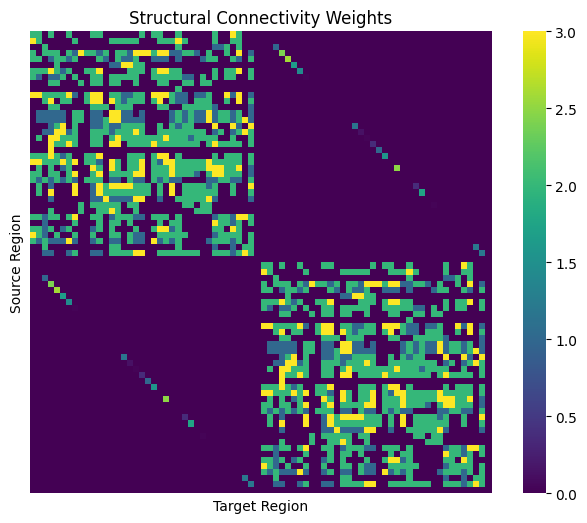

In [7]:
plt.figure(figsize=(8, 6))
sns.heatmap(weights_matrix, cmap="viridis", square=True, xticklabels=False, yticklabels=False)
plt.title("Structural Connectivity Weights")
plt.xlabel("Target Region")
plt.ylabel("Source Region")
plt.show()

Below is the matrix that stores the physical distances between every pair of brain regions (the tract length) in the TVB connectivity object.

In [8]:
tract_lengths = conn.tract_lengths  # Shape: (n_regions, n_regions)
print("Shape of tract lengths matrix:", tract_lengths.shape)

Shape of tract lengths matrix: (76, 76)


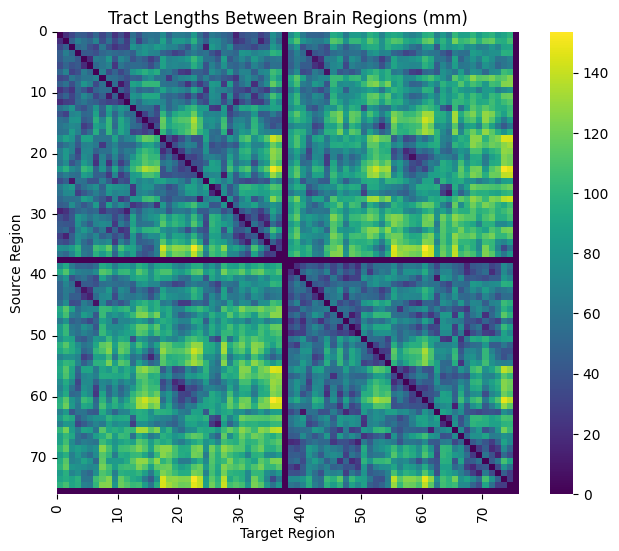

In [9]:
plt.figure(figsize=(8, 6))
axis = sns.heatmap(conn.tract_lengths, cmap="viridis", square=True)

# Set ticks every 10
tick_positions = np.arange(0, n_regions, 10)
axis.set_xticks(tick_positions)
axis.set_yticks(tick_positions)
axis.set_xticklabels(tick_positions, rotation=90)
axis.set_yticklabels(tick_positions, rotation=0)

plt.title("Tract Lengths Between Brain Regions (mm)")
plt.xlabel("Target Region")
plt.ylabel("Source Region")
plt.show()

This heatmap above shows the distances (mm) between pairs of brain regions, where brighter colors indicate longer tract lengths and the block structure shows the hemispheric organization.

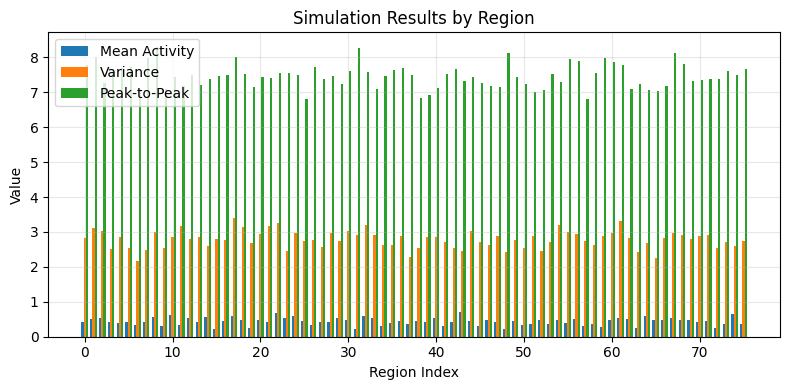

In [10]:
plt.figure(figsize=(8, 4))
regions = np.arange(n_regions)
width = 0.25

plt.bar(regions - width, mean_vals, width, label='Mean Activity')
plt.bar(regions, var_vals, width, label='Variance')
plt.bar(regions + width, ptp_vals, width, label='Peak-to-Peak')
plt.title('Simulation Results by Region')
plt.xlabel('Region Index')
plt.ylabel('Value')
plt.legend()
plt.xticks(regions[::10])  # Show every 10th region label
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The chart shows the summary statistics of neural activity for each brain region during the simulation:

Blue represents the mean activity, indicating the average signal level per region.

Orange shows the variance, reflecting how much the signal fluctuates around the mean.

Green represents the peak-to-peak amplitude, which is the difference between the highest and lowest values of the signal.

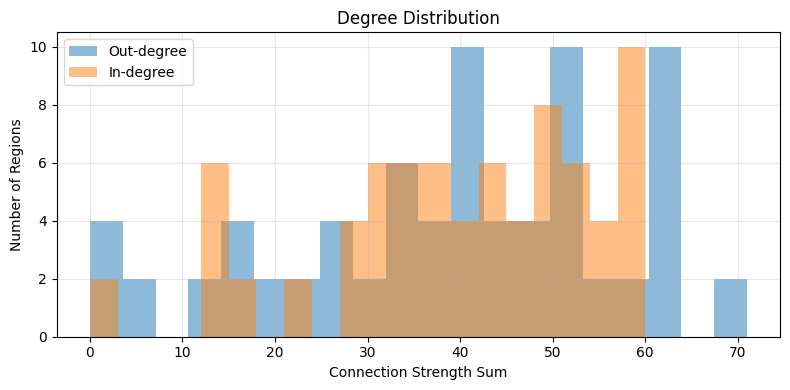

In [11]:
plt.figure(figsize=(8, 4))
out_degree = weights_matrix.sum(axis=1)
in_degree = weights_matrix.sum(axis=0)

plt.hist(out_degree, bins=20, alpha=0.5, label='Out-degree')
plt.hist(in_degree, bins=20, alpha=0.5, label='In-degree')
plt.title('Degree Distribution')
plt.xlabel('Connection Strength Sum')
plt.ylabel('Number of Regions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

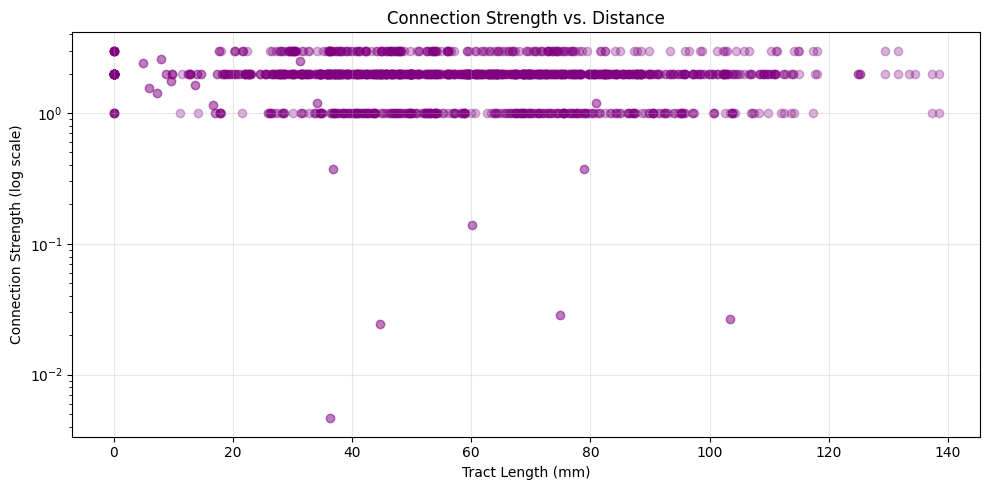

In [12]:
plt.figure(figsize=(10, 5))
flat_weights = weights_matrix.flatten()
flat_lengths = tract_lengths.flatten()
nonzero_idx = flat_weights > 0

plt.scatter(flat_lengths[nonzero_idx], flat_weights[nonzero_idx],
            alpha=0.3, color='purple')
plt.title('Connection Strength vs. Distance')
plt.xlabel('Tract Length (mm)')
plt.ylabel('Connection Strength (log scale)')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

The graph shows that most brain connection strengths are concentrated around 1 across a wide range of tract lengths.

# Machine Learning

Here we separate the TVB dataset into X features and y label vectors to create our Machine Learning task. This might take a few minutes.

In [13]:
X = []
y = []

for _ in range(n_simulations):
    X.append(run_simulation(stimulate=False))
    y.append(0)

for _ in range(n_simulations):
    X.append(run_simulation(stimulate=True))
    y.append(1)

X = np.array(X)
y = np.array(y)

In [14]:
print(X.shape)
print(y.shape)
print("Unique labels in y:", np.unique(y))
print("Number of distinct classes:", len(np.unique(y)))
print(type(X))
print(type(y))

(200, 228)
(200,)
Unique labels in y: [0 1]
Number of distinct classes: 2
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


X contains 200 samples, each representing the result of one brain simulation.

Each sample is a vector of 3 × 76 regions = 228, where each value is the mean activity of a specific brain region over the entire simulation.

y is a label array with 200 elements, where:

0 indicates a resting state simulation (no external stimulation).

1 indicates a stimulated state simulation (external input applied to one or more brain regions).



In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

After splitting the train and test sets we choose the ML models that we want to use in the cross validation.

In [22]:
# Define models
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(C=0.1, penalty='l2', random_state=42))
    ]),
    "SVM": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(random_state=42))
    ]),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier())
    ])
}

# Define parameter grids
param_grids = {
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    "Decision Tree": {
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10]
    },
    "KNN": {
        'clf__n_neighbors': [3, 5, 7],
        'clf__weights': ['uniform', 'distance']
    }
}

In [23]:
# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate models
for name, model in models.items():
    if name in param_grids:
        grid = GridSearchCV(model, param_grids[name], cv=cv, scoring='f1')
        grid.fit(X_train, y_train)
        best_score = grid.best_score_
        print(f"{name} (tuned): Mean F1 = {best_score:.3f}")
    else:
        scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
        print(f"{name}: Mean F1 = {scores.mean():.3f}, Std = {scores.std():.3f}")

Logistic Regression: Mean F1 = 0.801, Std = 0.112
SVM: Mean F1 = 0.393, Std = 0.083
Random Forest (tuned): Mean F1 = 0.561
Decision Tree (tuned): Mean F1 = 0.762
KNN (tuned): Mean F1 = 0.520


We see that Logistic Regression gave the best results so we choose it as our final model.

In [24]:
clf = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(C=0.1, penalty='l2', random_state=42))])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

In [25]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.94      0.81        31
           1       0.89      0.59      0.71        29

    accuracy                           0.77        60
   macro avg       0.80      0.76      0.76        60
weighted avg       0.80      0.77      0.76        60



It is seen that Logistic Regression classifier gives a good result in distinguishing between resting-state and stimulus-evoked brain activity.
The classifier achieved an accuracy of 77% on the test set. While the model performed strongly in identifying resting-state samples (high recall), it was comparatively less effective at detecting stimulus-evoked samples, as reflected in the lower recall for class 1 (stimulus).

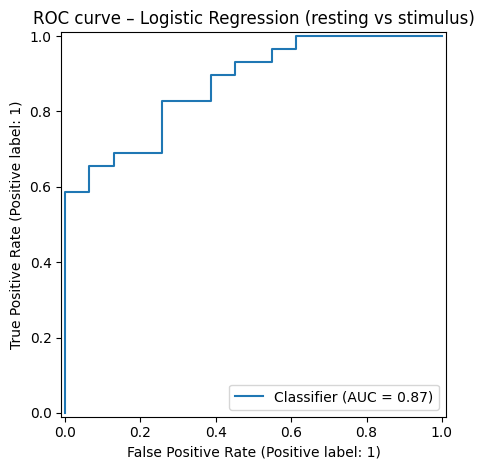

In [26]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC curve – Logistic Regression (resting vs stimulus)")
plt.tight_layout()
plt.show()

The ROC curve above demonstrates the classifier is good at distinguishing the classes, suggesting good separability between the two states.

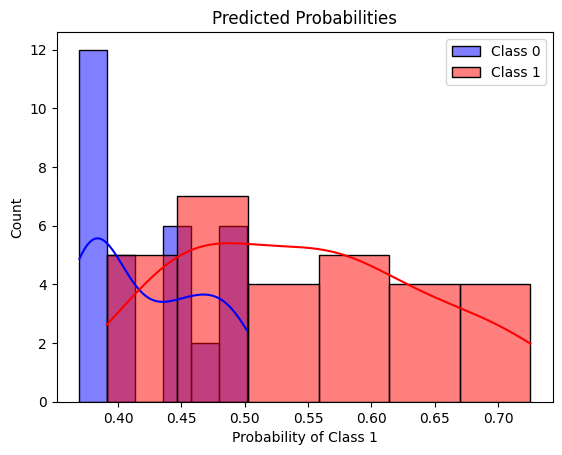

In [27]:
sns.histplot(y_proba[y_test == 0], color='blue', label='Class 0', kde=True)
sns.histplot(y_proba[y_test == 1], color='red', label='Class 1', kde=True)
plt.legend()
plt.title("Predicted Probabilities")
plt.xlabel("Probability of Classes")
plt.show()

In [29]:
!pip install shap

We have 200 samples with 228 different features.

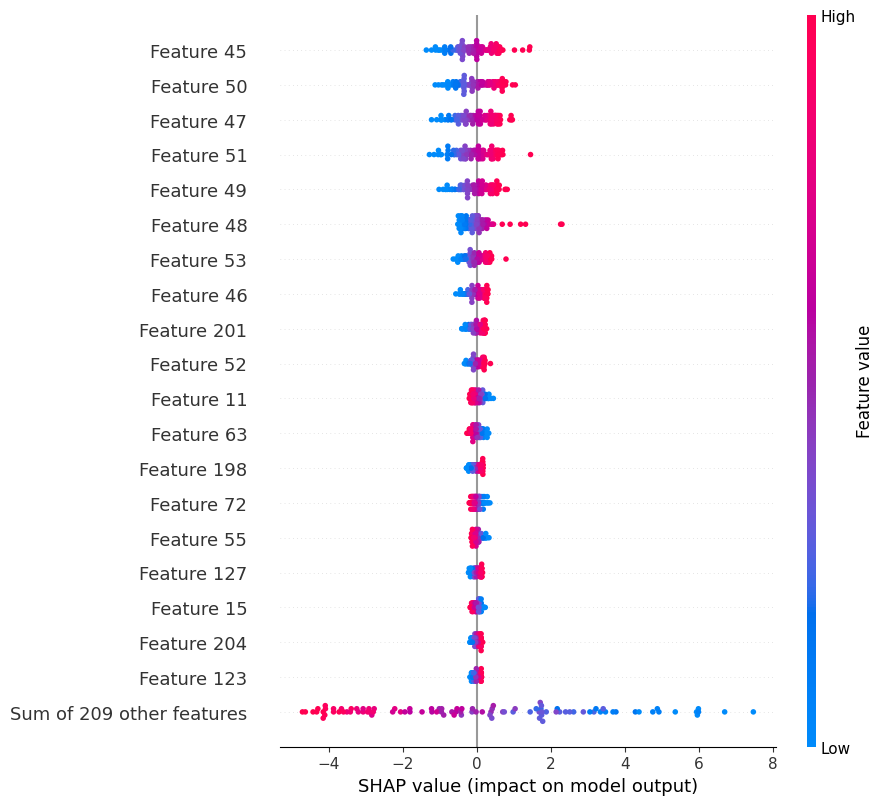

In [30]:
import shap

logreg_model = clf.named_steps['clf']
scaler = clf.named_steps['scaler']

X_scaled = scaler.transform(X_train)

# Create SHAP explainer
explainer = shap.Explainer(logreg_model, X_scaled)

# Compute SHAP values for 100 samples
shap_values = explainer(X_scaled[:100])

# Plot summary (feature importance)
shap.plots.beeswarm(shap_values, max_display=20)

SHAP explains which number of brain regions were the most significant in the machine learning model's predictions.